# Burgers' Equation with Crank-Nicolson Finite Differences
    Jared Nielsen

In [4]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import scipy.optimize as optimize
%matplotlib notebook

# Newton's Method

In [50]:
def newton(f, x0, Df, args=(), tol=1e-5, maxiters=30, alpha=1.):
    """Use Newton's method to approximate a zero of the function f.

    Parameters
        f (function): a function from R^n to R^n (assume n=1 until Problem 5).
        x0 (float or ndarray): The initial guess for the zero of f.
        Df (function): The derivative of f, a function from R^n to R^(nxn).
        tol (float): Convergence tolerance. The function should returns when
            the difference between successive approximations is less than tol.
        maxiters (int): The maximum number of iterations to compute.
        alpha (float): Backtracking scalar (Problem 3).

    Returns
        (float or ndarray): The approximation for a zero of f.
        (bool): Whether or not Newton's method converged.
        (int): The number of iterations computed.
    """
    converged = False
    x_prev = x0
    if np.isscalar(x0):
        for i in range(maxiters):
            x_cur = x_prev - alpha * f(x_prev, *args)/Df(x_prev, *args)
            if np.abs(x_cur - x_prev) < tol:
                converged = True
                break
            x_prev = x_cur
        approx = x_cur
        iters = i + 1
        return x_cur, converged, iters
    else:
        for i in range(maxiters):
            y_k = np.linalg.solve(Df(x_prev, *args), f(x_prev, *args))
            x_cur = x_prev - alpha * y_k
            if np.linalg.norm(x_cur - x_prev) < tol:
                converged = True
                break
            x_prev = x_cur
        approx = x_cur
        iters = i + 1
        return x_cur, converged, iters
    
def bfgs(Df, x0, maxiter=80, tol=1e-5, args=None):
    """Use BFGS to minimize a function f:R^n -> R.

    Parameters:
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate optimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    def update_A_inv(A_inv, s, y, sTy):
        first_term = (sTy + y.T@A_inv@y)*np.outer(s, s) / (sTy)**2
        second_term = (np.outer(A_inv@y, s) + np.outer(s, y)@A_inv) / (sTy)
        return A_inv + first_term - second_term

    n = len(x0)
    converged = False
    A_inv = np.eye(n)
    x_cur = x0
    Dfx_cur = Df(x_cur, *args)

    for i in range(maxiter):
        x_prev = x_cur
        Dfx_prev = Dfx_cur
        x_cur = x_prev - A_inv@Dfx_prev.T
        Dfx_cur = Df(x_cur, *args)
        if la.norm(Dfx_cur, ord=2) < tol:
            converged = True
            break
        s = x_cur - x_prev
        y = Dfx_cur.T - Dfx_prev
        sTy = np.dot(s, y)
        if sTy == 0:
            break
        A_inv = update_A_inv(A_inv=A_inv, s=s, y=y, sTy=sTy)

    iters = i
    return x_cur, converged, iters

# Residuals and Jacobian

In [51]:
def residuals(U1, U0, K1, K2, h_aj, h_bj, c_aj, c_bj, d_aj, d_bj, h):
    """The nonlinear implicit Crank-Nicholson equations for 
    the transformed Burgers' equation.

    Robin boundary conditions are
    h_a(t) = c_a(t) * u(a, t) + d_a(t) * u_x(a, t)
    h_b(t) = c_b(t) * u(b, t) + d_b(t) * u_x(b, t)
    
    Parameters
        U1 (ndarray): The values of U^(n+1)
        U0 (ndarray): The values of U^n
        s (float): wave speed
        K1 (float): first constant in the equations
        K2 (float): second constant in the equations
        h_aj (float): left side of boundary condition, h_a(t)
        h_bj (float): left side of boundary condition, h_b(t)
        c_aj (float): boundary condition coefficient, c_a(t)
        c_bj (float): c_b(t)
        d_aj (float): d_a(t)
        d_bj (float): d_b(t)
        h (float): space step size (dx)
    
    Returns
        out (ndarray): The residuals (differences between right- and 
                    left-hand sides) of the equation, accounting 
                    for boundary conditions.
    """
    lhs = U1[1:-1] - U0[1:-1]
    rhs_1 = K1*((-U1[1:-1])*(U1[2:] - U1[:-2]) + (-U0[1:-1]) * (U0[2:] - U0[:-2]))
    rhs_2 = K2*((U1[2:] -2 * U1[1:-1] + U1[:-2]) + (U0[2:] - 2 * U0[1:-1] + U0[:-2]))
    rhs = rhs_1 + rhs_2
    
    a_condition = (h * c_aj - d_aj) * U1[0]  + d_aj * U1[1]
    b_condition = (h * c_bj + d_bj) * U1[-1] - d_bj * U1[-2]

    res = np.concatenate(([h * h_aj - a_condition], lhs - rhs, [h * h_bj - b_condition]))
    return res

def residuals_jac(U1, U0, K1, K2, h_aj, h_bj, c_aj, c_bj, d_aj, d_bj, h):
    """The Jacobian (multi-dimensional gradient) of the residuals method.
          --                                                                                --
          | (-h c_aj + d_aj)  (-d_aj)               0                0             0  ...  0 |
          | (K1 U1[1] - K2)   (K1 (U1[0] - U1[2]))  (K1 U1[1] - K2)  0             0  ...  0 |
    jac = | 0  ...  0          `-.                   `-.             `-.           0  ...  0 |
          | 0  ...  0  (K1 U1[k] - K2)  (K1 (U1[k-1] - U1[k+1]))  (K1 U1[k] - K2)  0  ...  0 |
          | 0  ...  0          `-.                   `-.             `-.         `-.  ...  0 |
          | 0  ...            ...          ...           ...    (-d_bj) ... (-h c_bj - d_bj) |
           --                                                                              --

    Parameters 
        same as in `residuals`.

    Returns
        jac (ndarray): the Jacobian of the Crank-Nicholson equations for the Burgers' equation.
    """

    N_x = U1.shape[0]  
    Df = np.zeros((N_x, N_x))
    
    # fill the main diagonal
    Df[1:-1, 1:-1] = np.diag(1 + K1 * (U1[2:] - U1[:-2]) + 2 * K2)
    Df[0, 0] = d_aj - h * c_aj
    Df[-1, -1] = -d_bj - h * c_bj
    
    # fill the left off-diagonal
    Df[1:-1, :-2] += np.diag(K1 * U1[1:-1] - K2)
    Df[-1, -2] = -d_bj
    
    # fill the right off-diagonal
    Df[1:-1, 2:] += np.diag(K1 * U1[1:-1] - K2)
    Df[0, 1] = -d_aj

    return Df

def residuals_scalar(*args, **kwargs):
    return 0.5 * np.sum(residuals(*args, **kwargs)**2)

def residuals_scalar_prime(*args, **kwargs):
    f_vals = residuals(*args, **kwargs)
    fprime_vals = residuals_jac(*args, **kwargs)
    result = np.matmul(fprime_vals.T, f_vals)
    return result

# Iteration over Timesteps

In [54]:
def check_input(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b):
    if not a < b:
        raise ValueError("a must be less than b")

    if not T > 0:
        raise ValueError("T must be positive")

    if not N_x > 2:
        raise ValueError("N_x must be greater than 2")
    
    if not N_t > 1:
        raise ValueError("N_t must be greater than 1")
    

def burgers_equation(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b):
    # a - float
    # b - float, a < b
    # T - positive float
    # N_x - positive integer, N_x > 2, N_x = number of mesh nodes in x
    # N_t - positive integer, N_t > 1, N_t = number of mesh nodes in t
    # u_0 - function handle for the initial function auxiliary condition
    # c_a - function handle
    # d_a - function handle
    # h_a - function handle
    # c_b - function handle
    # d_b - function handle
    # h_b - function handle
    # U - a two dimensional numpy array containing floats.
    # Rows correspond to time and columns to x.

    check_input(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b)

    # create mesh nodes
    x = np.linspace(a, b, N_x)
    t = np.linspace(0, T, N_t)
    
    # helper variables
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    K1 = dt/(4*dx)
    K2 = dt/(2*(dx**2))

    # initial condition
    U0 = u_0(x)
    Us = [U0]
    
    # iterate over timesteps
    for t_i in t[1:]:
        args = (Us[-1], K1, K2, h_a(t_i), h_b(t_i), c_a(t_i), c_b(t_i), d_a(t_i), d_b(t_i), dx)
        # U_i = optimize.fsolve(func=f, x0=Us[-1], args=args) # isolate solver and finite difference logic
#         U_i = optimize.fmin_bfgs(f=residuals_scalar, x0=Us[-1], fprime=residuals_scalar_prime, args=args)
        U_i, converged, iters = newton(f=residuals, x0=Us[-1], Df=residuals_jac, args=args)
#         U_i, converged, iters = bfgs(Df=residuals_scalar_prime, x0=Us[-1], args=args)
        # print("converged: {}, iters: {}".format(converged, iters))
        Us.append(U_i)
    
    return np.array(Us)

# Test Case

solved finite difference method


<IPython.core.display.Javascript object>


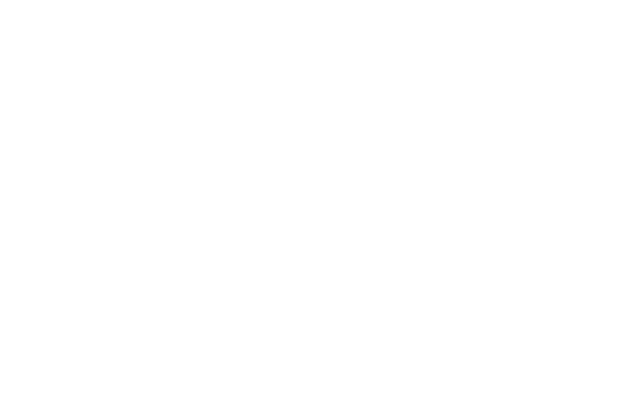

saved animation


In [55]:
def test_burgers():
    """Test case for Burger's Equation, u(x, t) = 1 - tanh((x - t) / 2)
    """
    
    a = -1
    b = 1
    T = 1
    N_x = 100
    N_t = 100
    h_a = lambda t: 1-np.tanh((a-t)/2) - 1/(2*np.cosh((a-t)/2)**2)
    h_b = lambda t: 1-np.tanh((b-t)/2) - 1/(2*np.cosh((b-t)/2)**2)
    c_a = lambda t: 1
    c_b = lambda t: 1
    d_a = lambda t: 1
    d_b = lambda t: 1

    u_hat = lambda x: 1 - np.tanh(x/2)
    u_true = lambda x, t: 1 - np.tanh((x-t)/2)
    v = lambda x: 0.35*(np.sin(3*x)+1)*(1/np.sqrt(2*np.pi))*np.exp(-x**2 /2)
    u_0 = lambda x: u_hat(x) #+ v(x)

    x = np.linspace(a, b, N_x)
    Us = burgers_equation(a, b, T, N_x, N_t, u_0, c_a, d_a, h_a, c_b, d_b, h_b)
    print("solved finite difference method")

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    ax.plot(x, u_hat(x), color='orange', label=r"$\hat{u}(x,0)$")
    ax.plot(x, u_true(x, T), color='purple', label=r"$\hat{u}(x,T)$")
    func, = ax.plot(x, Us[-1], color='g', label=r"$u(x,t)$")

    ax.set_xlim([a, b])
    # ax.set_ylim([0, 2])
    ax.set_title("Crank-Nicolson Method")
    ax.legend()
    plt.show()

    def update(i):
        func.set_data(x, Us[i])
        return func

    ani = animation.FuncAnimation(fig, update, frames=list(range(len(Us))), interval=25)
    ani.save("tanh(x).mp4")
    plt.close()
    print("saved animation")

test_burgers()

<video src="tanh(x).mp4" controls>